# **Libraries and Utilities**

In [ ]:
!pip install plotly
!pip install Lifetimes
# !pip install nb_black

In [ ]:
pip install squarify

In [ ]:
import os
import datetime
import squarify
import warnings
import pandas as pd
import numpy as np
import datetime as dt
from operator import attrgetter
import seaborn as sns
import matplotlib as mpl
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objs as go
from plotly.offline import iplot
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score)
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
%matplotlib inline
#load_ext nb_black
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
palette = 'Set2'

In [ ]:
mpl.rc("axes", titlesize=18, titlepad=15, titleweight=500)
mpl.rc("axes.spines", right=False, top=False)
mpl.rc("figure", figsize=(10, 5.5))
mpl.rc("font", family="serif", size=10)


def annotate_column_chart(ax: Axes):
    """Add annotations to a column chart.

    Args:
        ax (matplotlib.axes.Axes): A column chart.

    Returns:
        matplotlib.axes.Axes: Annotated column chart.
    """
    for p in ax.patches:
        p.set_width(0.7)
        ax.annotate(f"{p.get_height():,}", ha="center",
                xy=(p.get_x() + p.get_width() / 2, p.get_height() * 1.01))
    return ax


# **Loading the dataset**

In [ ]:
!gdown 1UAMw9eSDY9PV6M3qm6VOyrEbWrnIgrOL


Downloading...
From: https://drive.google.com/uc?id=1UAMw9eSDY9PV6M3qm6VOyrEbWrnIgrOL
To: /content/Copy of Ecom_CRM_analysis.csv
100% 45.6M/45.6M [00:00<00:00, 137MB/s]


In [ ]:
df = pd.read_csv("Copy of Ecom_CRM_analysis.csv", encoding='unicode_escape',
                 dtype = {'CustomerID': str,
                          'InvoiceID': str},
                 parse_dates = ['InvoiceDate'],
                 infer_datetime_format = True)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom



# Dataset Description
___________________

This dataset encompasses transactions from **01/12/2010 to 09/12/2011** for a non-store online retail business based and registered in the UK. Specializing in distinctive all-occasion gifts, the company's clientele includes a significant number of wholesale customers.
    


**Variable Description**
    
- **InvoiceNo:** Invoice number that consists 6 digits. If this code starts with letter 'c', it indicates a cancellation.
- **StockCode:** Product code that consists 5 digits.
- **Description:** Product name.
- **Quantity:** The quantities of each product per transaction.
- **InvoiceDate:** Represents the day and time when each transaction was generated.
- **UnitPrice:** Product price per unit.
- **CustomerID:** Customer number that consists 5 digits. Each customer has a unique customer ID.
- **Country:** Name of the country where each customer resides.

# **Analysing basics metrics**

In [ ]:
def check_data(dataframe, head=5):
    print(" LENGTH OF DF ".center(80,'-'))
    print(f"Length of df : {len(df)}")
    print(" SHAPE ".center(80,'-'))
    print(f"Number of rows in df : {df.shape[0]}")
    print(f"Number of columns in df : {df.shape[1]}")
    print(" COLUMNS ".center(80,'-'))
    print(df.columns)
    print(" HEAD ".center(80,'-'))
    print(dataframe.head(head))
    print(" MISSING VALUES ".center(80,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(80,'-'))
    print(dataframe.duplicated().sum())
    print(" QUANTILES ".center(80,'-'))
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_data(df)

--------------------------------- LENGTH OF DF ---------------------------------
Length of df : 541909
------------------------------------ SHAPE -------------------------------------
Number of rows in df : 541909
Number of columns in df : 8
----------------------------------- COLUMNS ------------------------------------
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
------------------------------------- HEAD -------------------------------------
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDat

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df["Country"].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [ ]:
def unique(i):
  print(f"Number of unique {i} : {df[i].nunique()}")
  print("**************************************")

cols = ["InvoiceNo", "StockCode","CustomerID", "Country"]

for ele in cols :
  unique(ele)

Number of unique InvoiceNo : 25900
**************************************
Number of unique StockCode : 4070
**************************************
Number of unique CustomerID : 4372
**************************************
Number of unique Country : 38
**************************************


**Observations **

---



Our data comprises of  **4372+** customers who have placed **25900 orders** for **4070 products** from **38 different countries**.


In [ ]:
def distribution(i):
  print(df[i].value_counts(normalize = True)*100)

In [ ]:
df["Country"].value_counts(normalize = True) * 100

United Kingdom          91.431956
Germany                  1.752139
France                   1.579047
EIRE                     1.512431
Spain                    0.467422
Netherlands              0.437527
Belgium                  0.381798
Switzerland              0.369435
Portugal                 0.280305
Australia                0.232327
Norway                   0.200403
Italy                    0.148180
Channel Islands          0.139876
Finland                  0.128250
Cyprus                   0.114779
Sweden                   0.085254
Unspecified              0.082302
Austria                  0.073998
Denmark                  0.071783
Japan                    0.066063
Poland                   0.062926
Israel                   0.054806
USA                      0.053699
Hong Kong                0.053145
Singapore                0.042258
Iceland                  0.033585
Canada                   0.027864
Greece                   0.026942
Malta                    0.023436
United Arab Em

## World Map

These are 38 unique countries. United kingdom has the major share of these orders amounting to 91%. Let's check the distribution on world map.

In [ ]:
world_map = df[['CustomerID', 'InvoiceNo', 'Country']
              ].groupby(['CustomerID', 'InvoiceNo', 'Country']
                       ).count().reset_index(drop = False)
countries = world_map['Country'].value_counts()
data = dict(type='choropleth',
            locations = countries.index,
            locationmode = 'country names',
            z = countries,
            text = countries.index,
            colorbar = {'title':'Orders'},
            colorscale='Tropic',
            reversescale = False)

layout = dict(title={'text': "Number of Orders by Countries",
                     'y':0.9,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'},
              geo = dict(resolution = 50,
                         showocean = True,
                         oceancolor = "LightBlue",
                         showland = True,
                         landcolor = "whitesmoke",
                         showframe = True),
             template = 'plotly_white',
             height = 600,
             width = 1200)

choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = False)

## Top 20 best selling products

Our data contains 25900 orders for 4070 unique products. Below are the top 20 best selling products.

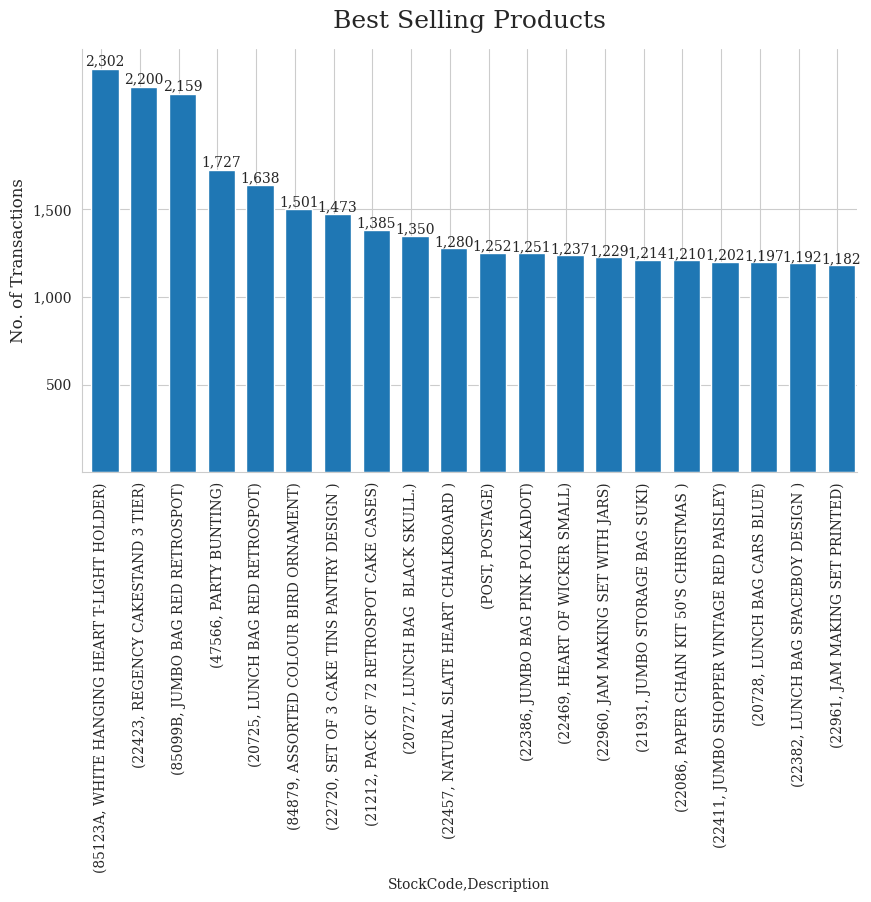

In [ ]:
item_counts = df[["StockCode","Description"]].value_counts()

ax = item_counts.nlargest(20).plot(kind="bar", title="Best Selling Products")
ax.set_ylabel("No. of Transactions", size=12)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([500, 1000, 1500]))


_ = annotate_column_chart(ax)

## To 20 Basket sizes

In [ ]:
basket_size = df.groupby("InvoiceNo")["StockCode"].count().reset_index()

basket_size["StockCode"].mean()

21.467630556754425

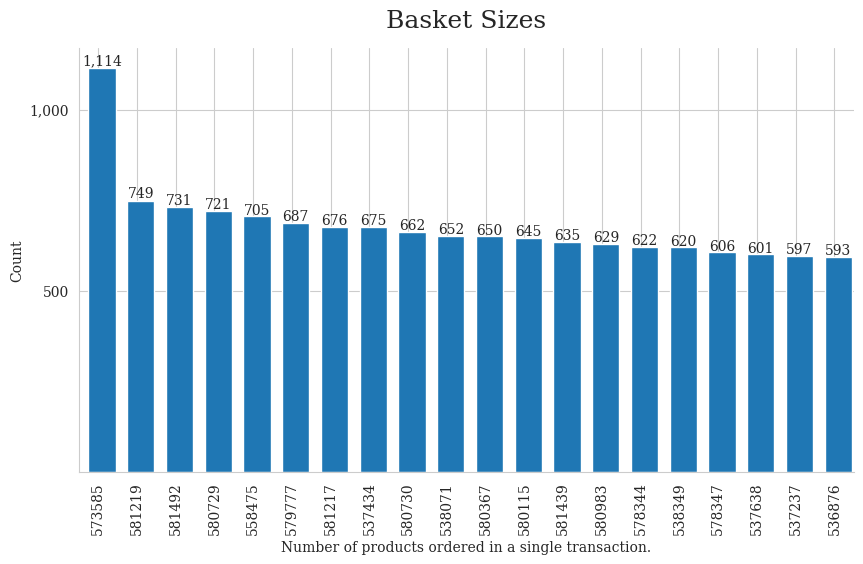

In [ ]:
#basket_sizes = data.notna().apply(sum, axis=1)

basket_size = df.groupby("InvoiceNo")["StockCode"].count()

ax = basket_size.nlargest(20).plot.bar(title="Basket Sizes")
ax.set_ylabel("Count")
ax.set_xlabel("Number of products ordered in a single transaction.")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator([500, 1000, 1500]))

_ = annotate_column_chart(ax)

## Creating new features


In [ ]:
df1 = df.copy()
df1["Order_month"] = df1["InvoiceDate"].dt.month
df1["Time"] = df["InvoiceDate"].dt.time
df1["Total_Sales"] = df1["Quantity"] * df1["UnitPrice"]

df1.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Order_month,Time,Total_Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,12,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,12,08:26:00,22.00


## Monthly and Quarterly sales volumes

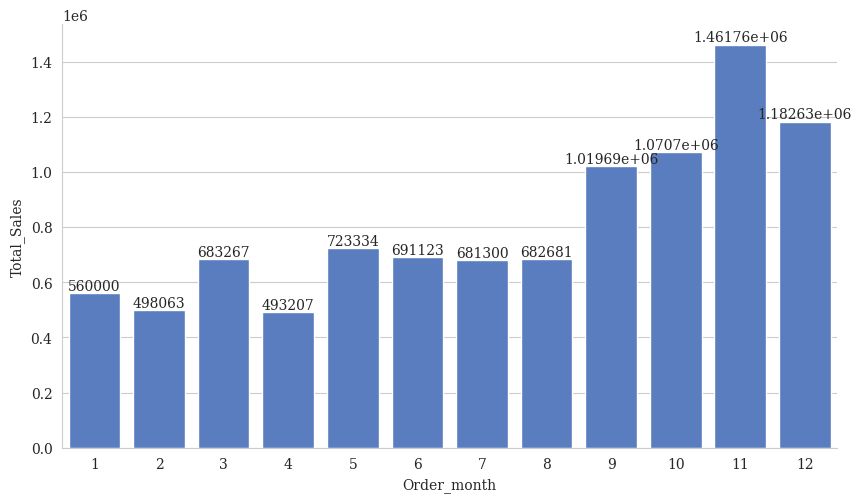

In [ ]:
a = df1.groupby("Order_month")["Total_Sales"].sum().reset_index()

sns.set_palette("muted")

ax = sns.barplot(a, x = "Order_month" , y = "Total_Sales")

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

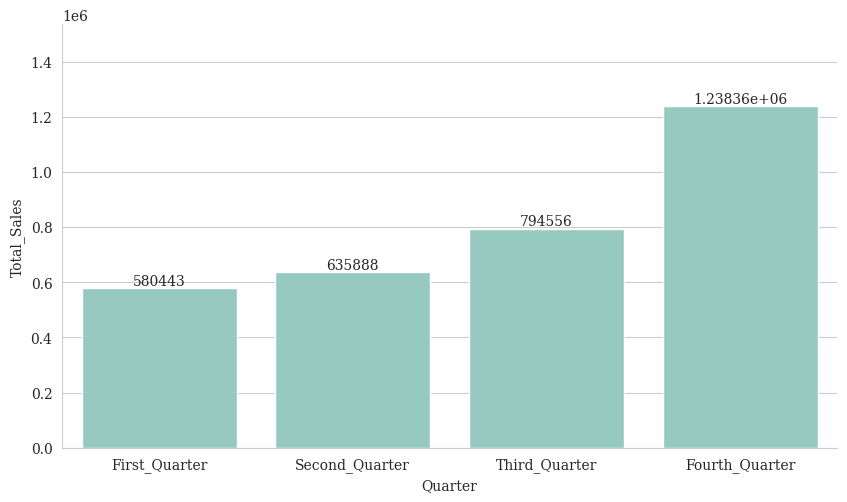

In [ ]:
bins=[0,3,6,9,12]
group=["First_Quarter",'Second_Quarter','Third_Quarter','Fourth_Quarter']

a['Quarter']= pd.cut(a['Order_month'],bins,labels=group)
sns.set_palette("Set3", 10)

ax = sns.barplot(a, x = "Quarter" , y = "Total_Sales", errwidth=0)

for i in ax.containers:
    ax.bar_label(i,)

plt.show()



## Monthly and quarterly order volume

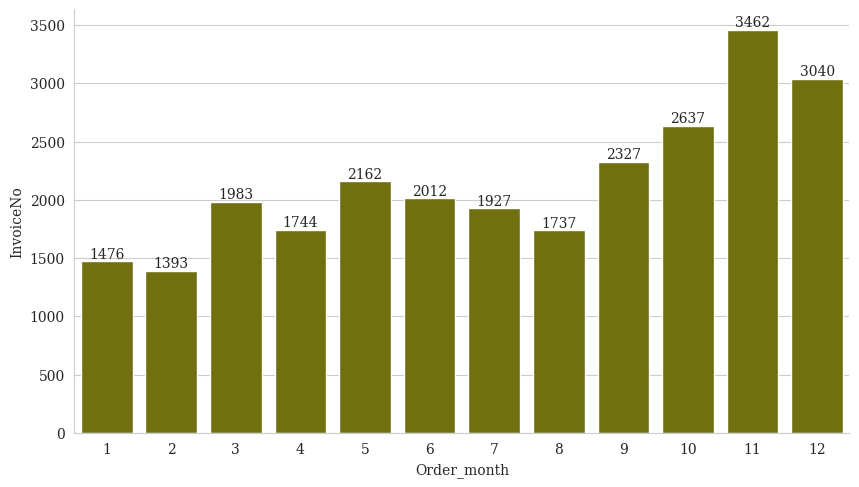

In [ ]:
b = df1.groupby("Order_month")["InvoiceNo"].nunique().reset_index()

sns.set_palette("Set3")

ax = sns.barplot(b, x = "Order_month" , y = "InvoiceNo", errwidth=0, color = "olive")

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

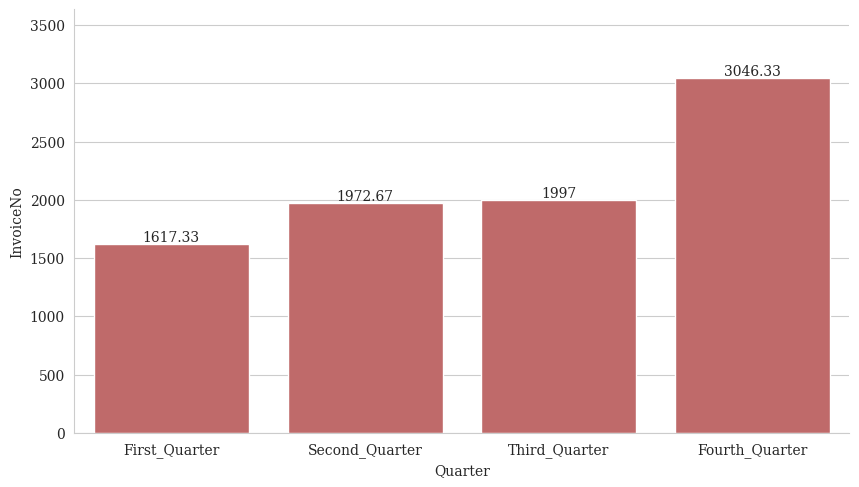

In [ ]:
bins=[0,3,6,9,12]
group=["First_Quarter",'Second_Quarter','Third_Quarter','Fourth_Quarter']

b['Quarter']= pd.cut(b['Order_month'],bins,labels=group)
sns.set_palette("Set2", 10)

ax = sns.barplot(b, x = "Quarter" , y = "InvoiceNo", errwidth=0, color = "indianred")

for i in ax.containers:
    ax.bar_label(i,)

plt.show()



## Products demand throughout the year.

Per month

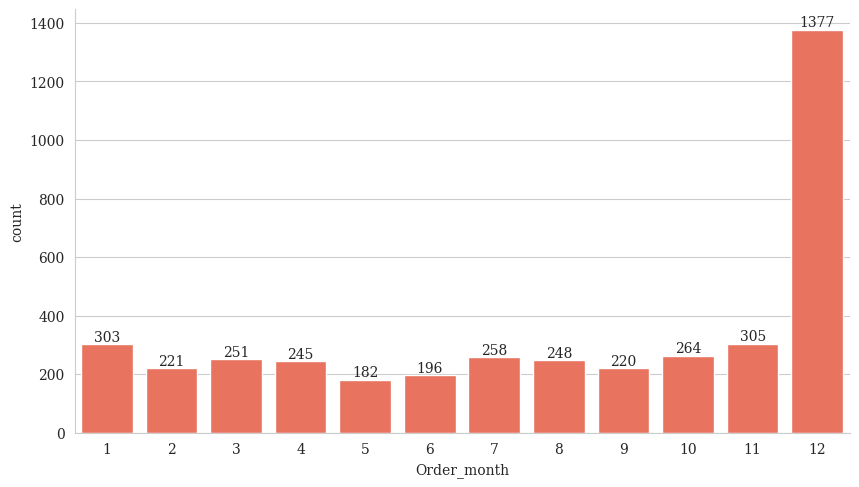

In [ ]:
c = df1.groupby("StockCode")["Order_month"].nunique().reset_index()
sns.set_palette("Set2", 10)

ax = sns.countplot(data = c, x = "Order_month", color = "tomato")

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

Based on grouping of months

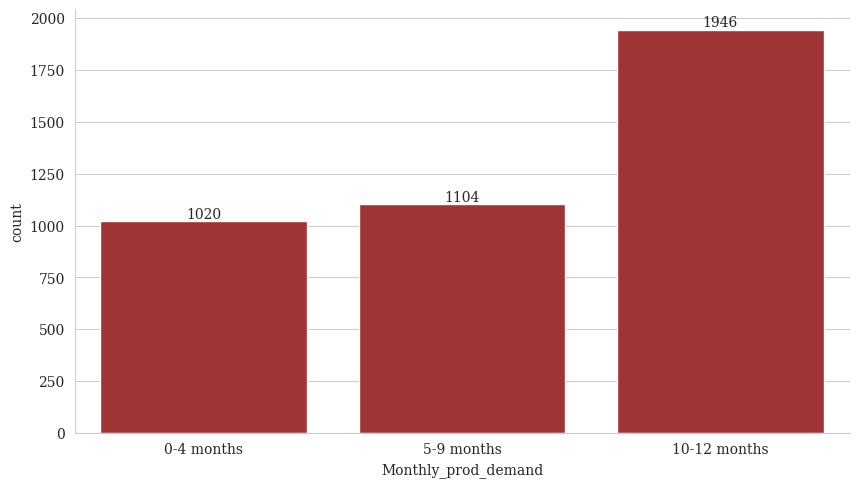

In [ ]:
bins=[0,4,9,12]
group=["0-4 months",'5-9 months','10-12 months']

c['Monthly_prod_demand']= pd.cut(c['Order_month'],bins,labels=group)

sns.set_palette("Set2", 10)

ax = sns.countplot(data = c, x = "Monthly_prod_demand", color = "firebrick")

for i in ax.containers:
    ax.bar_label(i,)

plt.show()

* Out of 4070 products we have 1377 products that are in demand all 12 months.

* If we group the monthly demand we can see 1976 products offered by company are in demand for 10 + months in a year.


## Top 20 highest spending customers.

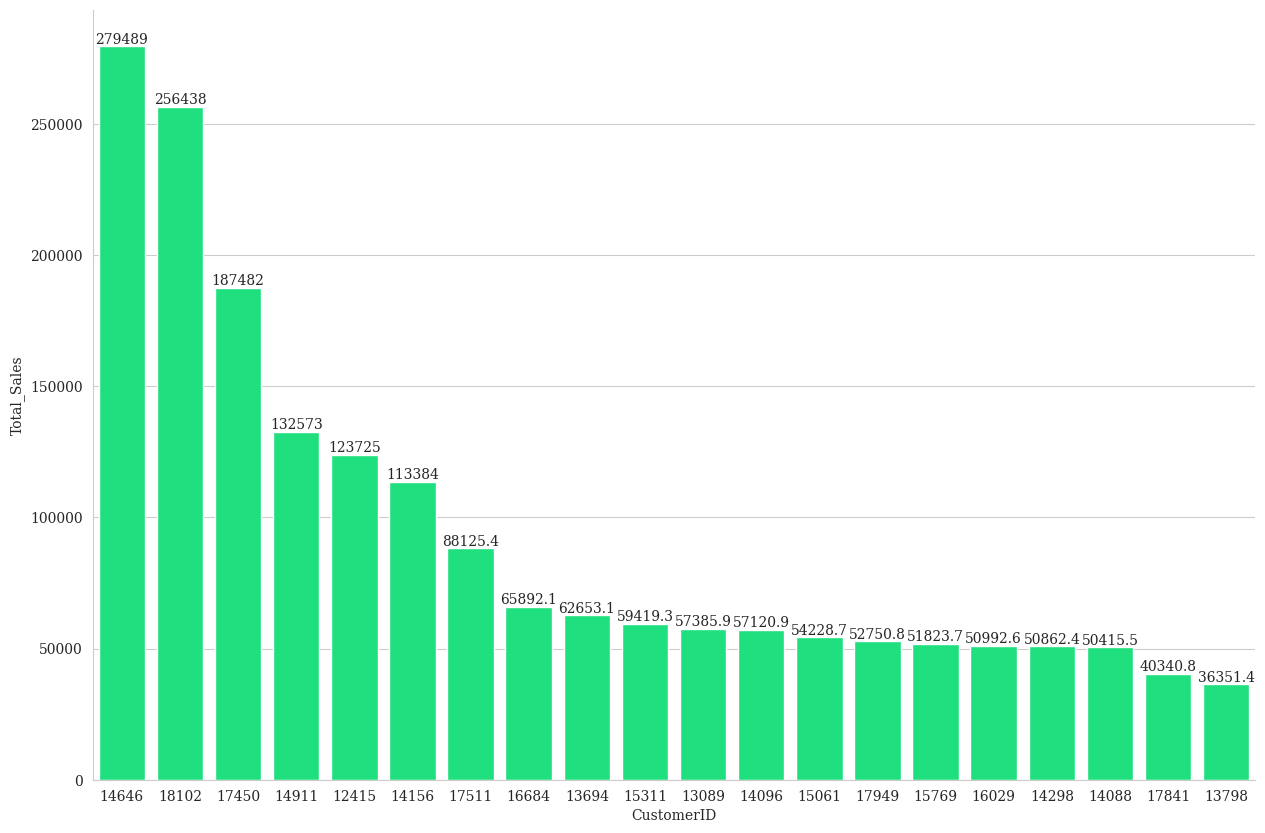

In [ ]:
highest_spend = df1.groupby("CustomerID")["Total_Sales"].sum().reset_index()

top_20 = highest_spend.sort_values("Total_Sales", axis=0, ascending=False).iloc[:20]

fig, ax = plt.subplots(figsize=(15, 10))


ax = sns.barplot(data = top_20, x = "CustomerID", y = "Total_Sales", color = "springgreen")



for i in ax.containers:
    ax.bar_label(i,)

plt.show()

## **Peak hours of day**

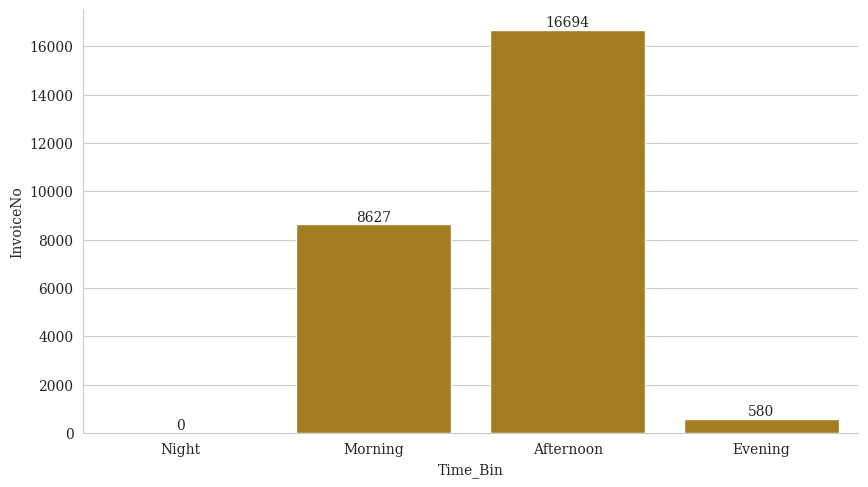

In [ ]:
bins = [0, 6, 12, 18, 24]

# add custom labels if desired
labels = ["Night",'Morning','Afternoon','Evening']

# add the bins to the dataframe
df1['Time_Bin'] = pd.cut(df1["InvoiceDate"].dt.hour, bins, labels=labels, right=False)

f = df1.groupby("Time_Bin")["InvoiceNo"].nunique().reset_index()

sns.set_palette("Set2", 10)

ax = sns.barplot(data = f, x = "Time_Bin", y = "InvoiceNo", color = "darkgoldenrod")

for i in ax.containers:
    ax.bar_label(i,)

plt.show()



* During afternoon maximum customer placed orders forllowed by morning.
* No orders are placed at night.

## **Descriptive Statistics**


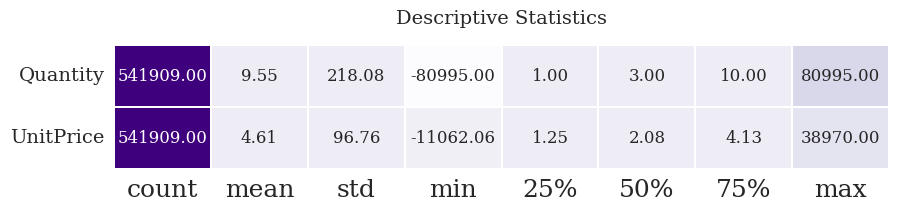

In [ ]:
def desc_stats(dataframe):
    desc_df = pd.DataFrame(index= dataframe.columns,
                           columns= dataframe.describe().T.columns,
                           data= dataframe.describe().T)

    f,ax = plt.subplots(figsize=(10,
                                 desc_df.shape[0] * 0.81))
    sns.heatmap(desc_df,
                annot = True,
                cmap = "Purples",
                fmt = '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.1,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 18)
    plt.yticks(size = 14,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()

desc_stats(df.select_dtypes(include = [float, int]))

*  Quantity and Unitprice relfect outliers.
*  Negative values in UnitPrice and Quantity might be because of **cancelled orders**. <br />
              


## **Data Preprocessing**

### Missing values and Outliers treatment

In [ ]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
a = df[df["Country"]== "United Kingdom"]

a.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

* There are 135080 missing values in Customer ID column.
* Out of there 133600 missing values are from United Kingdom.


**Handling missnig values.**

---

We find the top 5 customers who have placed most orders from United Kingdom and impute the missing values based on their percentage of orders to tha total orders from that country. However this will change the RFM scores for these users while conducting RFM anaylsis.Also with respect to other comparisons done above missing values in customer id column did not have any effect on the final output. Hence moving ahead for the RFM analysis we will be dropping these values form our dataset.

Outlier treatment


---

I am using inter Quartile range menthod to treat outliers from the data.


In [ ]:
def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):

    '''
    Detects outliers with IQR method and replaces with thresholds

    '''

    df_ = dataframe.copy()
    quartile1 = df_[variable].quantile(q1)
    quartile3 = df_[variable].quantile(q3)
    iqr = quartile3 - quartile1

    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr
    df_.loc[(df_[variable] < low_limit), variable] = low_limit
    df_.loc[(df_[variable] > up_limit), variable] = up_limit

    return df_

def ecommerce_preprocess(dataframe):
    df_ = dataframe.copy()

    #Missing Values
    df_ = df_.dropna()

    #Cancelled Orders & Quantity
    df_ = df_[~df_['InvoiceNo'].str.contains('C', na = False)]
    df_ = df_[df_['Quantity'] > 0]

    #Replacing Outliers
    df_ = replace_with_thresholds(df_, "Quantity", q1 = 0.01, q3 = 0.99)
    df_ = replace_with_thresholds(df_, "UnitPrice", q1 = 0.01, q3 = 0.99)

    #Total Price
    df_["TotalPrice"] = df_["Quantity"] * df_["UnitPrice"]

    return df_

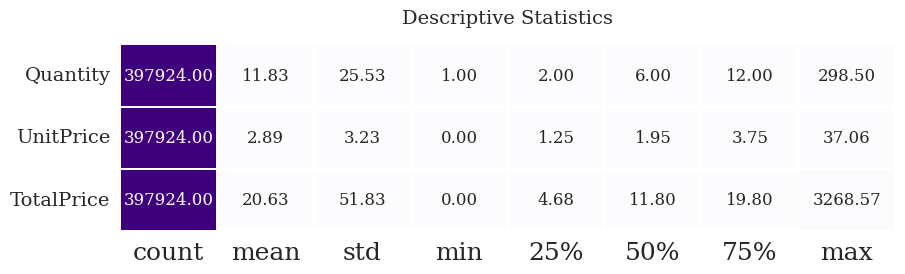

In [ ]:
df = ecommerce_preprocess(df)

desc_stats(df.select_dtypes(include = [float, int]))

In [ ]:
len(df)

397924

# RFM

RFM stands for **Recency**, **Frequency**, and **Monetary** value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.   

RFM factors illustrate these facts:

- The more recent the purchase, the more responsive the customer is to promotions
- The more frequently the customer buys, the more engaged and satisfied they are
- Monetary value differentiates heavy spenders from low-value purchasers

RFM Metrics

## **Feature creation** (Recency, Frequency, Monetary)

---



Assuming that this analysis is done 2 days after the max invoice date.


In [ ]:
print(df['InvoiceDate'].max())

2011-12-09 12:50:00


In [ ]:

today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'TotalPrice': lambda x: x.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm.reset_index()

rfm.head()

,CustomerID,recency,frequency,monetary
0,12346,326,1,310.44
1,12347,3,7,4310.00
2,12348,76,4,1770.78
3,12349,19,1,1491.72
4,12350,311,1,331.46


## **RFM Scores**

In [ ]:
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(df_["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5] )
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_SCORE"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(str)

    return df_


rfm = get_rfm_scores(rfm)

rfm


,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
0,12346,326,1,310.44,1,1,2,11
1,12347,3,7,4310.00,5,5,5,55
2,12348,76,4,1770.78,2,4,4,24
3,12349,19,1,1491.72,4,1,4,41
4,12350,311,1,331.46,1,1,2,11
...,...,...,...,...,...,...,...,...
4334,18280,278,1,180.60,1,2,1,12
4335,18281,181,1,80.82,1,2,1,12
4336,18282,8,2,178.05,5,3,1,53
4337,18283,4,16,2094.88,5,5,5,55



## **Segmentation**

In [ ]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346,326,1,310.44,1,1,2,11,hibernating
1,12347,3,7,4310.00,5,5,5,55,champions
2,12348,76,4,1770.78,2,4,4,24,at_Risk
3,12349,19,1,1491.72,4,1,4,41,promising
4,12350,311,1,331.46,1,1,2,11,hibernating


## **Segmentation Map**

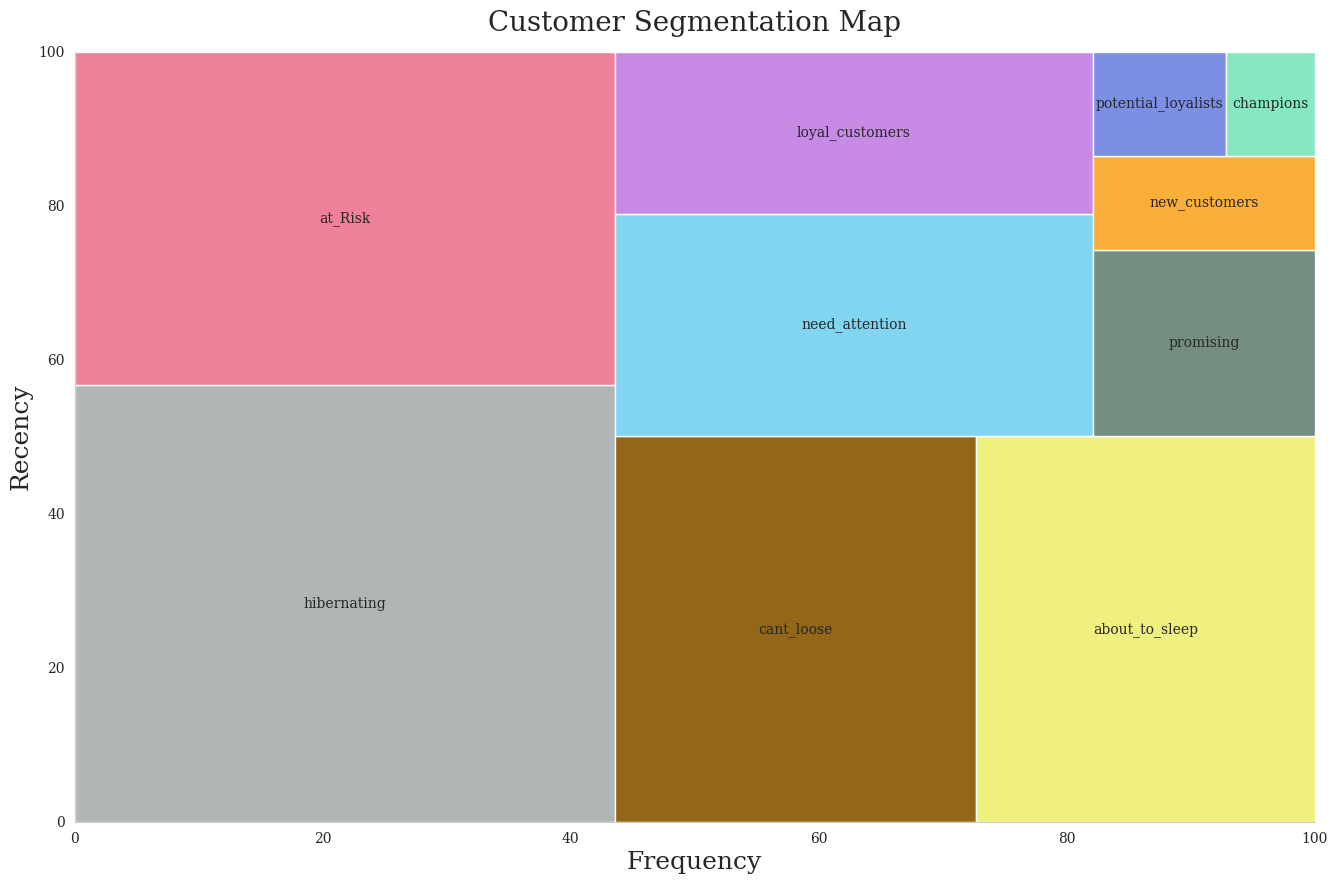

In [ ]:
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(
    sizes=segments,
    label=[label for label in seg_map.values()],
    color=[
        "#AFB6B5",
        "#F0819A",
        "#926717",
        "#F0F081",
        "#81D5F0",
        "#C78BE5",
        "#748E80",
        "#FAAF3A",
        "#7B8FE4",
        "#86E8C0",
    ],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 10},
)
plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)
plt.show()


# **Segment Analysis**

In [ ]:
rfm[['recency','monetary','frequency','segment']].groupby('segment').agg({'mean','std','max','min'})

recency                               monetary  \
                        max        mean        std min         max   
segment                                                              
about_to_sleep           72   53.312500  10.943474  34    6207.670   
at_Risk                 374  153.785835  68.618828  73   11072.670   
cant_loose              373  132.968254  65.250378  73   10254.180   
champions                13    6.361769   3.683300   1  266163.525   
hibernating             374  217.605042  92.013560  73    9182.345   
loyal_customers          72   33.608059  15.577050  15  120210.355   
need_attention           72   52.427807  11.552074  34    4353.830   
new_customers            13    7.428571   3.902112   1     848.550   
potential_loyalists      33   17.398760   9.338808   1    4628.750   
promising                33   23.421053   5.238115  15    1491.720   

                                                       frequency             \
                            mean           std     min       max       mean   
segment                                                                       
about_to_sleep        469.058097    533.161343    6.20         2   1.161932   
at_Risk               938.458341    943.170824   52.00         6   2.878583   
cant_loose           2646.822540   2008.352354   70.02        34   8.380952   
champions            6498.612978  18366.105822  198.23       210  12.417062   
hibernating           398.573036    553.714975    3.75         2   1.101774   
loyal_customers      2752.519574   5405.787839   36.56        63   6.479853   
need_attention        847.657086    732.298552    6.90         3   2.326203   
new_customers         314.883690    174.620952   89.94         1   1.000000   
potential_loyalists   674.628357    601.746293   20.80         3   2.010331   
promising             282.617158    224.363976    0.00         1   1.000000   

                                    
                           std min  
segment                             
about_to_sleep        0.368913   1  
at_Risk               0.954415   2  
cant_loose            4.289630   6  
champions            16.476484   3  
hibernating           0.302492   1  
loyal_customers       4.545669   3  
need_attention        0.470081   2  
new_customers         0.000000   1  
potential_loyalists   0.651401   1  
promising             0.000000   1

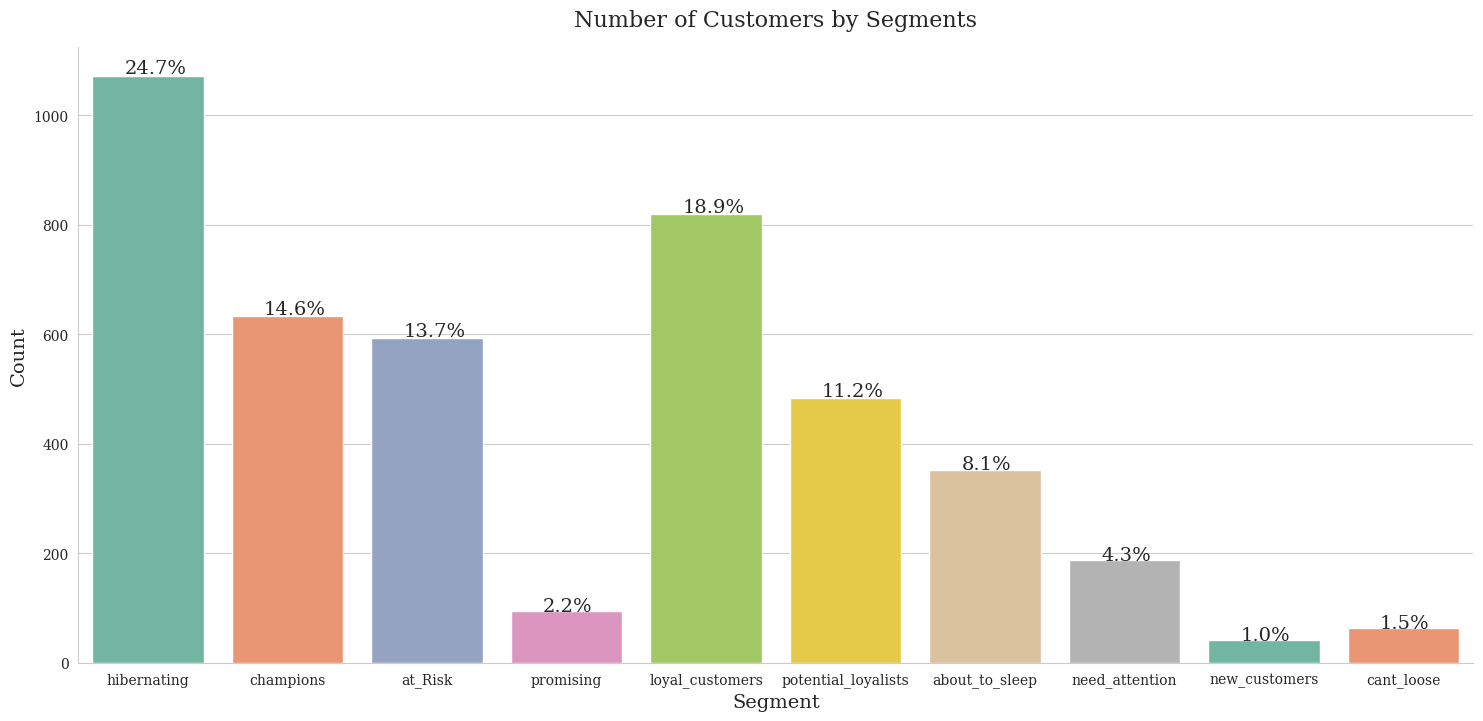

In [ ]:
plt.figure(figsize = (18, 8))
ax = sns.countplot(data = rfm,
                   x = 'segment',
                   palette = palette)
total = len(rfm.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

* Company has subtantial amount of customer who are hibernating, at risk or about_to_sleep.
* The percentage of potential loyalists is 10% which is a healthy percentage for company.

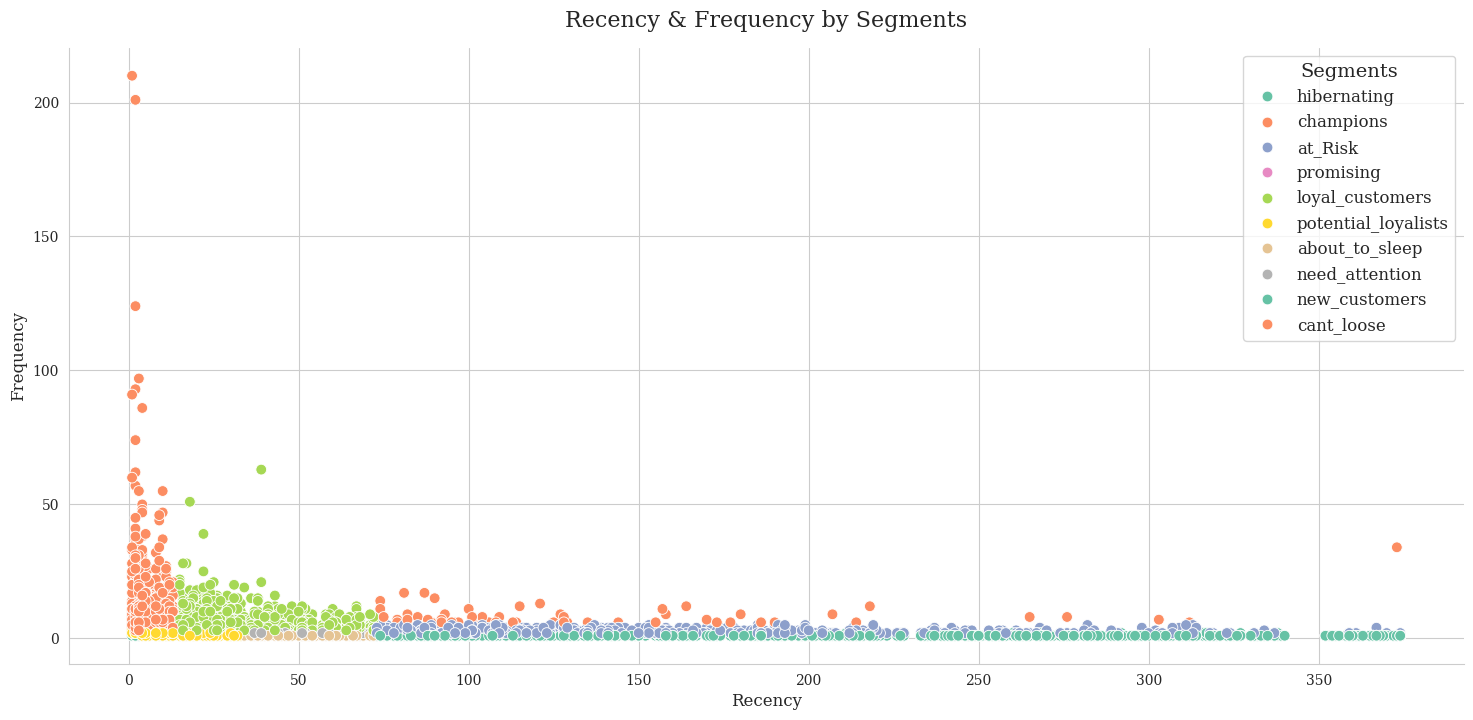

In [ ]:
plt.figure(figsize=(18, 8))
sns.scatterplot(
    data=rfm, x="recency", y="frequency", hue="segment", palette=palette, s=60
)
plt.title("Recency & Frequency by Segments", size=16)
plt.xlabel("Recency", size=12)
plt.ylabel("Frequency", size=12)
plt.xticks(size=10)
plt.yticks(size=10)
plt.legend(loc="best", fontsize=12, title="Segments", title_fontsize=14)
plt.show()

More the frequency score higher the recency score.

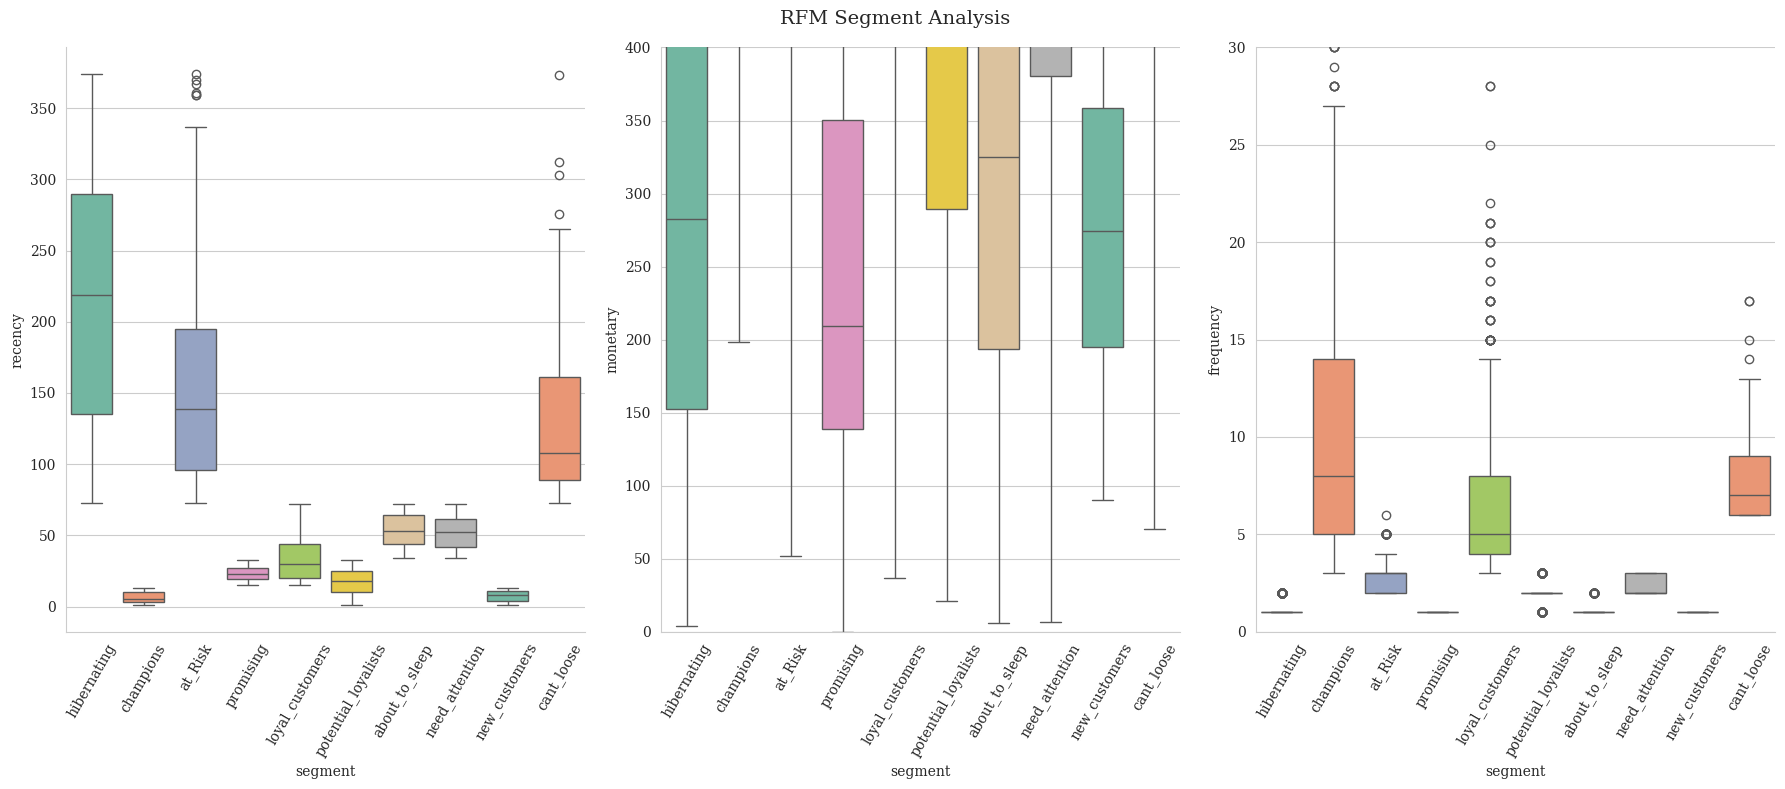

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle("RFM Segment Analysis", size=14)
feature_list = ["recency", "monetary", "frequency"]
for idx, col in enumerate(feature_list):
    sns.boxplot(
        ax=axes[idx], data=rfm, x="segment", y=feature_list[idx], palette=palette
    )
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=60)
    if idx == 1:
        axes[idx].set_ylim([0, 400])
    if idx == 2:
        axes[idx].set_ylim([0, 30])
plt.tight_layout()
plt.show()

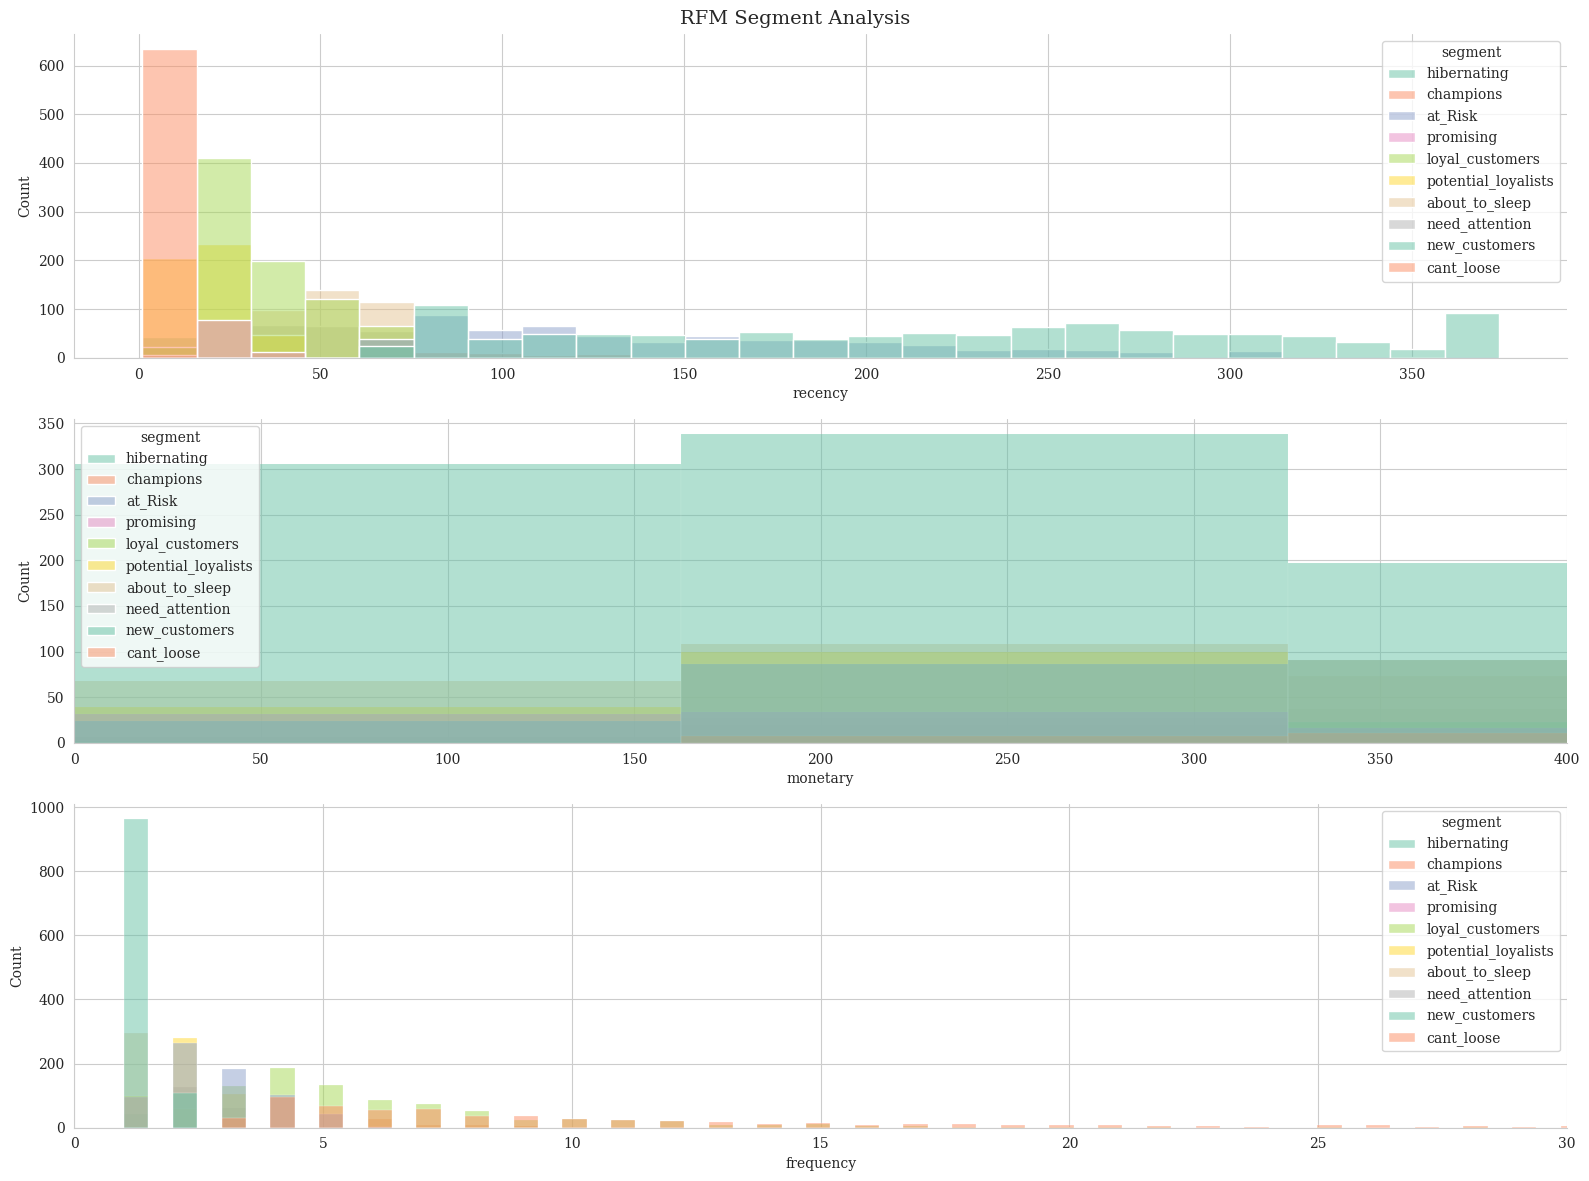

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('RFM Segment Analysis', size = 14)
feature_list = ['recency', 'monetary', 'frequency']
for idx, col in enumerate(feature_list):
    sns.histplot(ax = axes[idx], data = rfm,
                 hue = 'segment', x = feature_list[idx],
                 palette= palette)
    if idx == 1:
        axes[idx].set_xlim([0, 400])
    if idx == 2:
        axes[idx].set_xlim([0, 30])
plt.tight_layout()
plt.show()

# **Cohort Analysis**

A cohort is a group of people sharing something in common, such as the sign-up date to an app, the month of the first purchase, geographical location, acquisition channel (organic users, coming from performance marketing, etc.) and so on. In Cohort Analysis, we track these groups of users over time, to identify some common patterns or behaviors.

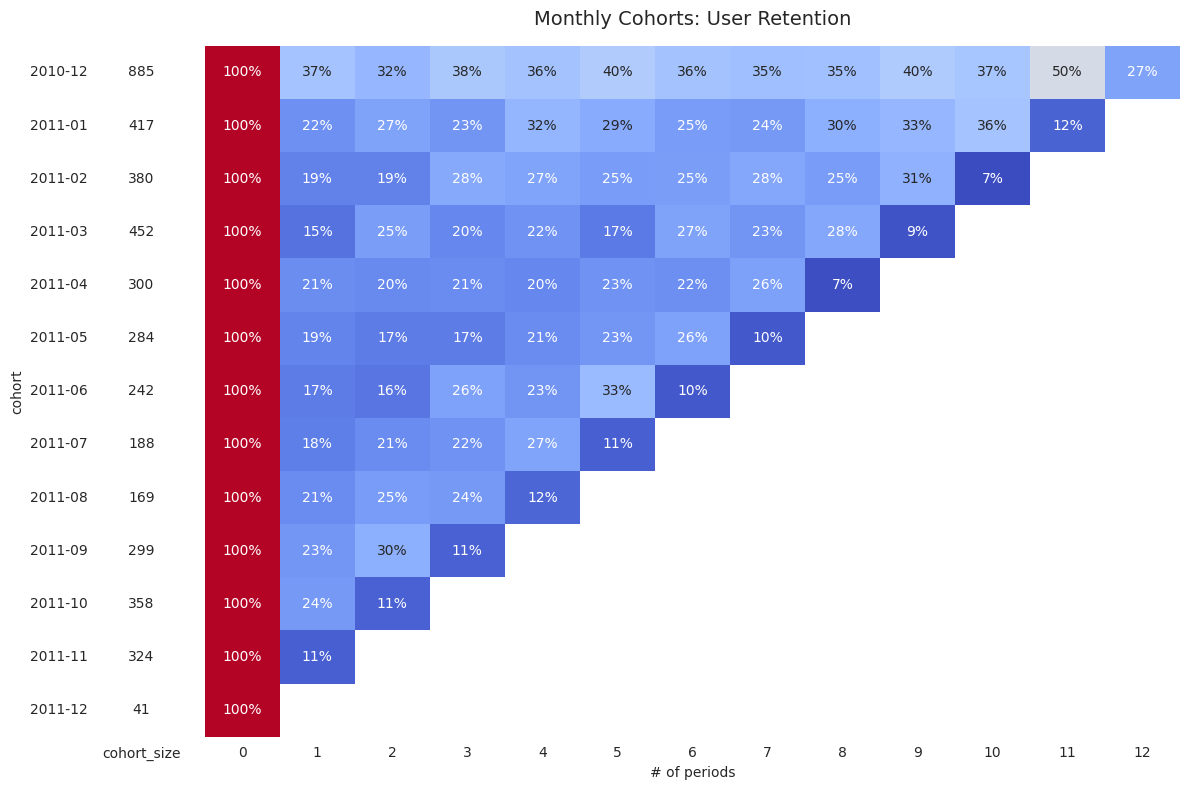

In [ ]:
def CohortAnalysis(dataframe):

    data = dataframe.copy()
    data = data[["CustomerID", "InvoiceNo", "InvoiceDate"]].drop_duplicates()
    data["order_month"] = data["InvoiceDate"].dt.to_period("M")
    data["cohort"] = ( data.groupby("CustomerID")["InvoiceDate"].transform("min").dt.to_period("M") )

    cohort_data = (
        data.groupby(["cohort", "order_month"])
        .agg(n_customers=("CustomerID", "nunique"))
        .reset_index(drop=False)
    )

    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(
        attrgetter("n")
    )
    cohort_pivot = cohort_data.pivot_table(
        index="cohort", columns="period_number", values="n_customers"
    )
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    with sns.axes_style("white"):
        fig, ax = plt.subplots(
            1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]}
        )
        sns.heatmap(
            retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            cbar=False,
            fmt=".0%",
            cmap="coolwarm",
            ax=ax[1],
        )
        ax[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax[1].set(xlabel="# of periods", ylabel="")
        white_cmap = mcolors.ListedColormap(["white"])
        sns.heatmap(
            pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"}),
            annot=True,
            cbar=False,
            fmt="g",
            cmap=white_cmap,
            ax=ax[0],
        )
        fig.tight_layout()

CohortAnalysis(df)

# Recommendations



---
Order volume and sales


---
* The order numbers and sales have gone high in the winter from Sep to Dec. This period also coincided with festive period.
* It would be recommended to run maximum campaigns during such periods as many users can be acquired during this time.
* For the months of January, February, March comapny can focus on running ad campaigns for targeted users to increase conversion rates.

---





Product return rate



---

* Out of 25900 orders 5172 orders contain products / order that have been returned/ cancelled by users. That is 19.96 % return rate marginally better than industry rate of 20 - 30 %. It would be recommended to pay attention to reasons behind cancelled orders and a detailed analysis to ensure we do not breach the threshold.


---



Inventory

---
 *  There are 1976 products which are in demand throught the year. It owuld be recommended to pay attention to inventory turnover and reorder points of this products.


---
RFM


---
* Company sould run marketing campaigns for customers who are hibernating,  at risk or about_to_sleep to drive more conversion rates.
* It would be recommended to pay more attention to loyalists and potential loyalists as it is easier to keep old customer than acquire new ones.


---

User retention rates

---
* It would be recommended to focus on way to users per month after they have been acquired.
* Separate focus can be put on user who stay with for more than 5 months.
* Specific loyalty bonuses, festive discounts, free items on bulk order would be few of the way to gain more trust and from such users.



